In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import numpy as np
import fireducks.pandas as pd
import matplotlib.pyplot as plt
import tempfile
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import torch.utils.data as data

from esm.utils.structure.protein_chain import ProteinChain
from esm.models.esm3 import ESM3
from esm.models.esmc import ESMC

from esm.utils.constants.esm3 import SEQUENCE_VOCAB
from esm.sdk.api import (
    ESMProtein,
    ESMProteinTensor,
    GenerationConfig,
    LogitsConfig,
    SamplingConfig,
)
from esm.utils.decoding import decode_structure
from esm.utils.constants.esm3 import STRUCTURE_BOS_TOKEN, STRUCTURE_EOS_TOKEN
from esm.utils.residue_constants import atom_order
from esm.utils.sampling import get_default_sampling_config
from esm.layers.rotary import RotaryEmbedding
from esm.layers.blocks import swiglu_ln_ffn, gelu_ln_ffn

from peft import get_peft_model, AdaLoraConfig
from trl import GRPOConfig, GRPOTrainer

device = torch.device("cuda")
sequence = "SPNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETNPGGSKHHHHHH"
protein = ESMProtein(sequence=sequence)


[2025-02-25 14:39:44,129] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/jupyter-chenxi/.conda/envs/frameflow/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/jupyter-chenxi/.conda/envs/frameflow/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [69]:
def extract_n_ca_c_positions(predicted_structure):
    N_INDEX = rc.atom_order['N']
    CA_INDEX = rc.atom_order['CA']
    C_INDEX = rc.atom_order['C']

    return predicted_structure[..., [N_INDEX, CA_INDEX, C_INDEX], :]


def robust_norm(x, mask=None, axis=-1, keepdims=False, eps=1e-8):
    """
    Compute the robust norm of a tensor along a specified axis, adding a small epsilon to avoid division by zero.
    Account for masking to avoid bias due to differing lengths of masked entries.
    """
    if mask is None:
        mask = torch.ones(x.shape[:-1], dtype=x.dtype, device=x.device)
    masked_x = x * mask.unsqueeze(axis)
    sum_squared = torch.sum(masked_x**2, dim=axis, keepdim=keepdims)
    norm = torch.sqrt(sum_squared + eps)
    return norm


def get_R(N, CA, C, mask=None):
    """
    Compute the rotation matrix that aligns the N, CA, and C atoms of a protein backbone.
    """
    v1 = C - CA
    v2 = N - CA

    e1 = v1 / robust_norm(v1, mask, axis=-1, keepdims=True)
    c = torch.sum(e1 * v2, dim=-1, keepdim=True)
    e2 = v2 - c * e1
    e2 = e2 / robust_norm(e2, mask, axis=-1, keepdims=True)
    e3 = torch.cross(e1, e2, dim=-1)

    return torch.stack([e1, e2, e3], dim=-1)


def get_ij(R, T):
    """
    Apply the rotation matrix R to the coordinates T to transform them.
    """
    delta = T[:, None, :, :] - T[:, :, None, :]
    transformed = torch.einsum('brji,brsj->brsi', R, delta)
    return transformed


def loss_fn(t, p, mask=None, clamp=10.0, eps=1e-8):
    """
    Compute the FAPE loss between transformed true and predicted coordinates.
    """
    if mask is None:
        mask = torch.ones(t.shape[0], t.shape[1], dtype=torch.bool, device=t.device)
    pair_mask = mask.unsqueeze(1) & mask.unsqueeze(2)
    fape = robust_norm(t - p, pair_mask)
    fape = torch.clamp(fape, max=clamp) / 10.0

    valid_mask_count = torch.sum(pair_mask, dim=(-1, -2)).clamp(min=1)
    
    masked_fape = fape * pair_mask
    mean_fape = torch.sum(masked_fape, dim=(-1, -2)) / (valid_mask_count + eps)

    return mean_fape


def compute_fape_loss(true_positions, pred_positions, mask=None, clamp=10.0):
    """
    Compute the FAPE loss between true and predicted backbone positions (N, CA, C),
    and apply a loss schedule to the computed FAPE values.
    """
    true_R = get_R(true_positions[:, :, 0, :], true_positions[:, :, 1, :], true_positions[:, :, 2, :], mask=mask)
    pred_R = get_R(pred_positions[:, :, 0, :], pred_positions[:, :, 1, :], pred_positions[:, :, 2, :], mask=mask)

    true_transformed = get_ij(true_R, true_positions[:, :, 1, :])
    pred_transformed = get_ij(pred_R, pred_positions[:, :, 1, :])
    
    loss_per_batch = loss_fn(true_transformed, pred_transformed, mask=mask, clamp=clamp)
    final_loss = loss_per_batch
    
    return final_loss

def masked_cross_entropy(logits, labels, mask, label_smoothing=0.0):
    logits = logits[mask]
    labels = labels[mask]
    loss = F.cross_entropy(logits, labels, reduction="mean", label_smoothing=label_smoothing)
    return loss

def new_masked_cross_entropy(logits, labels, mask, label_smoothing=0.0):
    loss = F.cross_entropy(logits.transpose(1, -1), labels.transpose(1, -1), reduction="none", label_smoothing=label_smoothing)
    loss[~mask] = 0.0
    loss = loss.sum(dim=-1) / (mask.sum(dim=-1) + 1e-8)
    return loss

def masked_kl_divergence(logits, labels, mask):
    logits = F.log_softmax(logits[mask], dim=-1)
    labels = torch.log(labels[mask])
    loss = F.kl_div(logits, labels, reduction="none", log_target=True).sum(dim=-1).mean()
    return loss

def new_masked_kl_divergence(logits, labels, mask):
    masked_logits = torch.clone(logits)
    masked_labels = torch.clone(labels)
    masked_logits[mask] = F.log_softmax(masked_logits[mask], dim=-1)
    masked_labels[mask] = torch.log(masked_labels[mask])
    loss = F.kl_div(masked_logits, masked_labels, reduction="none", log_target=True).sum(dim=-1)
    loss[~mask] = 0.0
    loss_per_batch = loss.sum(dim=-1) / (mask.sum(dim=-1) + 1e-8)
    return loss_per_batch

compute_fape_loss(torch.randn(2, 16, 3, 3), torch.randn(2, 16, 3, 3)).shape
x = torch.randn(2, 16, 3)
y = torch.zeros(2, 16, 3)
y[:, :, 0] = 1.0
y[:, :, 1:] = 1e-8
mask = torch.ones(2, 16, dtype=torch.bool)
mask[0, 8:] = 0
mask[1, 8:] = 0
print(masked_cross_entropy(x, y, mask))
print(new_masked_cross_entropy(x, y, mask))
assert torch.allclose(masked_cross_entropy(x, y, mask).sum(), new_masked_cross_entropy(x, y, mask).mean())
print("masked_kl_divergence", masked_kl_divergence(x, y, mask))
print("new_masked_kl_divergence", new_masked_kl_divergence(x, y, mask))
assert torch.allclose(masked_kl_divergence(x, y, mask).sum(), new_masked_kl_divergence(x, y, mask).mean()), str(masked_kl_divergence(x, y, mask).sum()) + " " + str(new_masked_kl_divergence(x, y, mask).mean())


tensor(1.1338)
tensor([0.7828, 1.4848])
masked_kl_divergence tensor(1.1338)
new_masked_kl_divergence tensor([0.7828, 1.4848])


In [3]:
def torch_kabsch(a, b):
    u, s, vh = torch.linalg.svd(a.T @ b, full_matrices=False)
    u[:, -1] = u[:, -1] * torch.sign(torch.det(u @ vh))
    return u @ vh


def torch_rmsd(true, pred):
    p = true - true.mean(0, keepdim=True)
    q = pred - pred.mean(0, keepdim=True)
    p = p @ torch_kabsch(p, q)
    return torch.sqrt(torch.sum((p - q) ** 2, dim=-1).mean())


def torch_rmsd_batch(true, preds):
    return torch.vmap(lambda x: torch_rmsd(true, x))(preds)


def tmscore(reference, predicted):
    """
    Calculate TM-score between reference and predicted CA coordinates
    Inputs:
        reference: torch.Tensor, shape [N, 3]
        predicted: torch.Tensor, shape [N, 3]
    Returns:
        list of two TM-scores: [normalized_by_reference_length, normalized_by_predicted_length]
    """
    # Create temporary files for the PDB data
    temp_files = []
    try:
        for n, z in enumerate([reference, predicted]):
            temp_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.pdb')
            temp_files.append(temp_file.name)
            with temp_file as out:
                for k, c in enumerate(z):
                    out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                              % (k+1, "CA", "ALA", "A", k+1, c[0], c[1], c[2], 1, 0))

        # Pass to USalign
        output = os.popen(f'/home/jupyter-chenxi/USalign/USalign {temp_files[0]} {temp_files[1]}')

        # Parse outputs
        parse_float = lambda x: float(x.split("=")[1].split()[0])
        o = []
        for line in output:
            line = line.rstrip()
            if line.startswith("TM-score"): o.append(parse_float(line))
    finally:
        # Cleanup: Ensure temporary files are removed after processing
        for fname in temp_files:
            os.remove(fname)

    return o


In [2]:
model = ESMC.from_pretrained("esmc_300m", device=device)
protein_tensor = model.encode(protein).to(device)
logits_output = model.logits(
   protein_tensor, LogitsConfig(sequence=True, structure=True, secondary_structure=True, 
   sasa=True, function=True, return_embeddings=True, return_hidden_states=True)
)
logits = logits_output.logits.sequence
embeddings = logits_output.embeddings
hidden_states = logits_output.hidden_states
print(logits.shape)
print(embeddings.shape)
print(hidden_states.shape)


Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 58457.20it/s]


torch.Size([1, 154, 64])
torch.Size([1, 154, 960])
torch.Size([30, 1, 154, 960])


In [12]:
model = ESM3.from_pretrained("esm3_sm_open_v1", device=device)
structure_prediction_config = GenerationConfig(
    track="structure",  # We want ESM3 to generate tokens for the structure track
    num_steps=len(sequence),
    temperature=0.7,
)
structure_prediction_prompt = ESMProtein(sequence=sequence)
structure_prediction = model.generate(
    structure_prediction_prompt, structure_prediction_config
)
structure_prediction.to_pdb("7BNY_esm3.pdb")


100%|██████████| 152/152 [00:06<00:00, 24.88it/s]


In [8]:
for name, param in model.named_parameters():
    print(name)


encoder.sequence_embed.weight
encoder.plddt_projection.weight
encoder.plddt_projection.bias
encoder.structure_per_res_plddt_projection.weight
encoder.structure_per_res_plddt_projection.bias
encoder.structure_tokens_embed.weight
encoder.ss8_embed.weight
encoder.sasa_embed.weight
encoder.function_embed.0.weight
encoder.function_embed.1.weight
encoder.function_embed.2.weight
encoder.function_embed.3.weight
encoder.function_embed.4.weight
encoder.function_embed.5.weight
encoder.function_embed.6.weight
encoder.function_embed.7.weight
encoder.residue_embed.weight
transformer.blocks.0.attn.layernorm_qkv.0.weight
transformer.blocks.0.attn.layernorm_qkv.0.bias
transformer.blocks.0.attn.layernorm_qkv.1.weight
transformer.blocks.0.attn.out_proj.weight
transformer.blocks.0.attn.q_ln.weight
transformer.blocks.0.attn.k_ln.weight
transformer.blocks.0.geom_attn.distance_scale_per_head
transformer.blocks.0.geom_attn.rotation_scale_per_head
transformer.blocks.0.geom_attn.s_norm.weight
transformer.blocks

In [14]:
for name, param in model.named_parameters():
    if name == "encoder.structure_tokens_embed.weight":
        print(param.shape)

torch.Size([4101, 1536])


In [ ]:
config = AdaLoraConfig(
    r=8,
    init_r=12,
    tinit=200,
    tfinal=1000,
    deltaT=10,
    target_modules=["query", "value"],
    modules_to_save=["classifier"],
)
model = get_peft_model(model, config)


## Mask Structure Encoding

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ESM3.from_pretrained("esm3_sm_open_v1", device=device).eval()
protein_obj = ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny.pdb", chain_id="B")
sequence = protein_obj.sequence # "PNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETN"
print(len(sequence), sequence)
true_coord = torch.from_numpy(protein_obj.atom37_positions)
true_coord = true_coord[:,:3].to(device)
attn_mask = torch.ones(1, len(sequence), device=device)

with torch.no_grad(), torch.amp.autocast("cuda", dtype=torch.bfloat16):
    protein = ESMProtein(sequence=sequence, coordinates=true_coord)
    protein_tensor = model.encode(protein)
sequence_tokens = protein_tensor.sequence

num_iter = 64
p_range = np.linspace(0.05, 1, 19)
rmsd_list = np.empty((len(p_range), num_iter))
tm_list = np.empty((len(p_range), num_iter))
with torch.no_grad():
    for i, p in tqdm(enumerate(p_range)):
        pred_coords = torch.empty(num_iter, len(sequence), 3, 3, device=device)
        for j in range(num_iter):
            mask_idx = np.random.choice(np.arange(len(sequence)), size=int(np.ceil(p * len(sequence))), replace=False)
            masked_attn_mask = attn_mask.clone()
            masked_attn_mask[0, mask_idx] = 0
            structure_tokens = model.get_structure_encoder().encode(true_coord[None], attention_mask=masked_attn_mask)[1][0]
            structure_tokens[mask_idx] = 4096
            structure_tokens = F.pad(structure_tokens, (1, 0), value=STRUCTURE_BOS_TOKEN)
            structure_tokens = F.pad(structure_tokens, (0, 1), value=STRUCTURE_EOS_TOKEN).to(device)

            masked_protein = ESMProteinTensor(sequence=sequence_tokens, structure=structure_tokens)
            protein_tensor = model.generate(masked_protein, GenerationConfig(track="structure", num_steps=8))
            save_protein = model.decode(protein_tensor)
            pred_coords[j] = save_protein.coordinates[:,:3]
        rmsd_list[i] = torch_rmsd_batch(true_coord[:, 1].float(), pred_coords[:, :, 1].float()).cpu().numpy()
        tm_list[i] = [tmscore(true_coord[:, 1].float(), pred_coords[j, :, 1].float())[0] for j in range(num_iter)]


140 PNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETN


100%|██████████| 7/7 [00:00<00:00, 23.31it/s]
/home/jupyter-chenxi/esm3/esm/models/vqvae.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
100%|██████████| 8/8 [00:00<00:00, 24.82it/s]
19it [08:12, 25.91s/it]


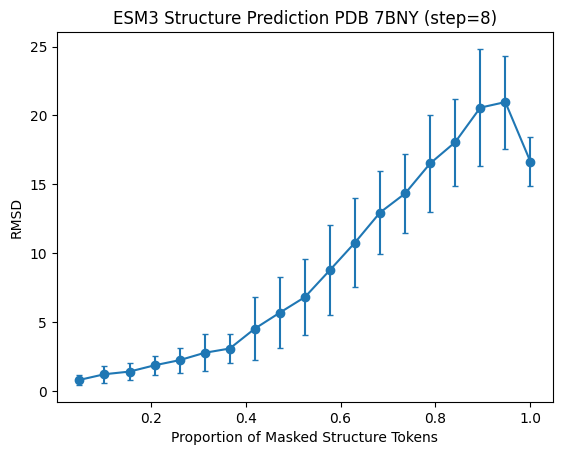

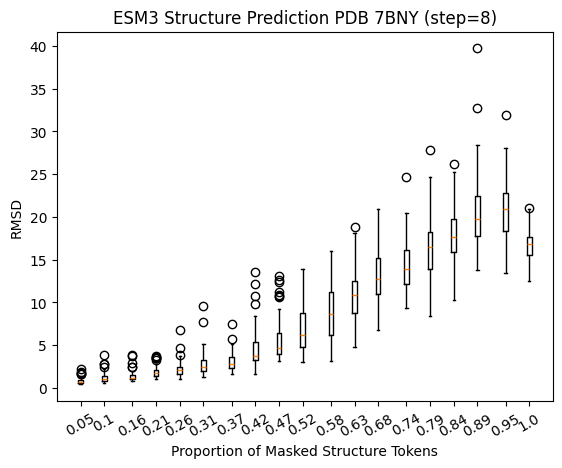

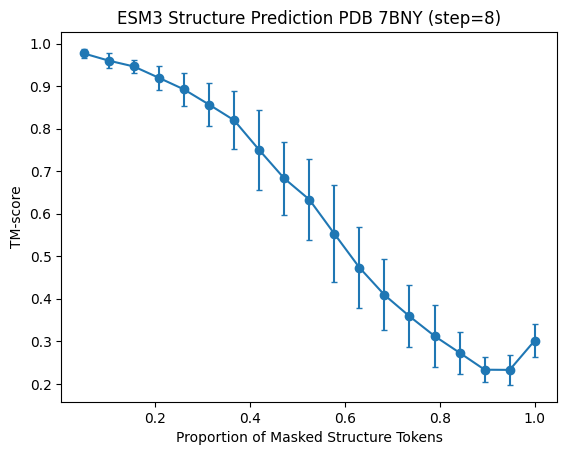

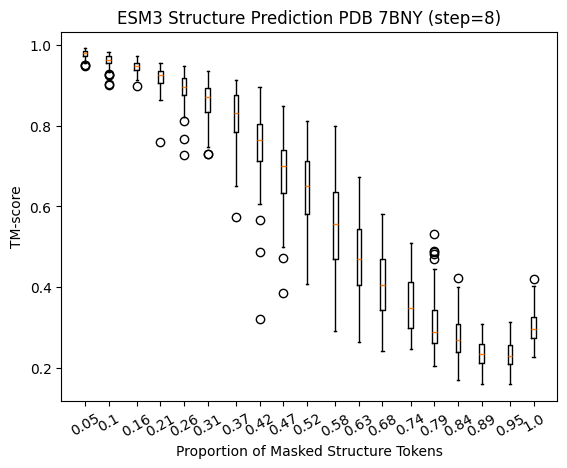

In [13]:
plt.errorbar(p_range, rmsd_list.mean(axis=1), yerr=rmsd_list.std(axis=1), fmt="o-", capsize=2.0)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("RMSD")
plt.show()

plt.boxplot(rmsd_list.T, positions=np.round(p_range, 2), widths=0.01)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("RMSD")
plt.xlim(0,1.05)
plt.xticks(rotation=30)
plt.show()

plt.errorbar(p_range, tm_list.mean(axis=1), yerr=tm_list.std(axis=1), fmt="o-", capsize=2.0)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("TM-score")
plt.show()

plt.boxplot(tm_list.T, positions=np.round(p_range, 2), widths=0.01)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("TM-score")
plt.xlim(0,1.05)
plt.xticks(rotation=30)
plt.show()

In [4]:
device = torch.device("cpu") # torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ESM3.from_pretrained("esm3_sm_open_v1", device=device).eval()
protein_obj = ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny.pdb", chain_id="B")
sequence = protein_obj.sequence # "PNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETN"
print(len(sequence), sequence)
true_coord = torch.from_numpy(protein_obj.atom37_positions)
true_coord = true_coord[:,:3].to(device)
attn_mask = torch.ones(1, len(sequence), device=device)

# with torch.no_grad(), torch.amp.autocast("cuda", dtype=torch.bfloat16):
protein = ESMProtein(sequence=sequence, coordinates=true_coord)
protein_tensor = model.encode(protein)
sequence_tokens = protein_tensor.sequence
structure_tokens = protein_tensor.structure


# num_iter = 64
# p_range = np.linspace(0.05, 1, 19)
# rmsd_list = np.empty((len(p_range), num_iter))
# tm_list = np.empty((len(p_range), num_iter))
# with torch.no_grad():
#     for i, p in tqdm(enumerate(p_range)):
#         pred_coords = torch.empty(num_iter, len(sequence), 3, 3, device=device)
#         for j in range(num_iter):
#             mask_idx = np.random.choice(np.arange(len(sequence)), size=int(np.ceil(p * len(sequence))), replace=False)
#             masked_attn_mask = attn_mask.clone()
#             masked_attn_mask[0, mask_idx] = 0
#             structure_tokens = model.get_structure_encoder().encode(true_coord[None], attention_mask=masked_attn_mask)[1][0]
#             structure_tokens[mask_idx] = 4096
#             structure_tokens = F.pad(structure_tokens, (1, 0), value=STRUCTURE_BOS_TOKEN)
#             structure_tokens = F.pad(structure_tokens, (0, 1), value=STRUCTURE_EOS_TOKEN).to(device)

#             masked_protein = ESMProteinTensor(sequence=sequence_tokens, structure=structure_tokens)
#             protein_tensor = model.generate(masked_protein, GenerationConfig(track="structure", num_steps=8))
#             save_protein = model.decode(protein_tensor)
#             pred_coords[j] = save_protein.coordinates[:,:3]
#         rmsd_list[i] = torch_rmsd_batch(true_coord[:, 1].float(), pred_coords[:, :, 1].float()).cpu().numpy()
#         tm_list[i] = [tmscore(true_coord[:, 1].float(), pred_coords[j, :, 1].float())[0] for j in range(num_iter)]


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/jupyter-chenxi/esm3/esm/pretrained.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


140 PNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETN


/home/jupyter-chenxi/esm3/esm/pretrained.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/jupyter-chenxi/esm3/esm/models/vqvae.py:286: Fut

In [5]:
p = 0.5
masked_structure_tokens = structure_tokens.clone()
mask_idx = np.random.choice(np.arange(1, len(structure_tokens)-1), size=int(np.ceil(p * (len(structure_tokens)-2))), replace=False)
masked_structure_tokens[mask_idx] = 4096

masked_protein_tensor = ESMProteinTensor(sequence=sequence_tokens, structure=masked_structure_tokens)
# protein_tensor = ESMProteinTensor(sequence=sequence_tokens, structure=structure_tokens)

logits = model.logits(masked_protein_tensor, LogitsConfig(
    structure=True,
    return_embeddings=True,
))
print(logits)
print(logits.logits.structure.shape)
print(logits.embeddings.shape)

fas_output = model.forward_and_sample(masked_protein_tensor, None)
print(fas_output.entropy.structure)

pred_masked_protein = model.decode(masked_protein_tensor)
print(pred_masked_protein)


LogitsOutput(logits=ForwardTrackData(sequence=None, structure=tensor([[[26.1935, 24.3623, 26.0522,  ..., 24.7016, 21.7564, 25.2343],
         [19.7517, 26.5368, 22.2064,  ..., 27.2592, 17.6623, 20.9605],
         [29.0195, 27.4310, 28.7636,  ..., 27.6740, 24.9861, 26.5517],
         ...,
         [33.6811, 24.5923, 35.0802,  ..., 24.5388, 22.0088, 28.3991],
         [30.1253, 22.7285, 33.5101,  ..., 22.3929, 18.9915, 28.1670],
         [25.9043, 23.0070, 27.6107,  ..., 23.0928, 19.7349, 20.6994]]]), secondary_structure=None, sasa=None, function=None), embeddings=tensor([[[  19.1820,   92.8048,  -93.2114,  ..., -224.6284,  -61.1463,
            49.4490],
         [  53.1741,  -64.9319,  233.8373,  ..., -240.4213,   -8.7414,
           246.2799],
         [  33.2103, -134.3258,  198.3162,  ..., -216.1412,  -67.1662,
           145.2575],
         ...,
         [-206.1983, -134.2358,   28.2021,  ...,  -33.9605,  -37.4933,
           -66.8033],
         [-146.0223, -102.3048,  164.0800,  .

/home/jupyter-chenxi/esm3/esm/utils/generation.py:624: UserWarning: For function sampling, invalid_ids sampling config is not supported.
  warn("For function sampling, invalid_ids sampling config is not supported.")


tensor([5.6830, 3.9334, 5.4639, 5.9266, 5.5436, 5.0325, 5.9764, 6.0532, 5.9481,
        4.6203, 3.2237, 2.3265, 3.0057, 2.7229, 2.3090, 2.2200, 1.2318, 3.3446,
        2.7908, 3.2522, 3.8767, 2.2065, 4.7896, 0.5929, 3.1880, 3.7623, 3.0310,
        2.1000, 2.8143, 2.5207, 4.1603, 2.1378, 1.8420, 2.9178, 2.0989, 2.0406,
        1.7729, 2.4141, 2.5680, 2.7538, 2.4782, 4.2777, 4.4872, 4.8161, 4.8113,
        4.4017, 3.7596, 3.0428, 3.1935, 3.9274, 3.9651, 3.7438, 3.3518, 3.6550,
        4.4398, 3.8916, 3.8253, 2.1763, 3.2112, 3.8573, 4.3847, 5.9801, 5.8295,
        5.2558, 4.7875, 5.0576, 3.5411, 5.1402, 3.9226, 2.9212, 3.8119, 4.1551,
        3.2018, 3.3153, 2.1207, 2.2067, 2.1766, 2.9890, 1.5760, 3.8463, 2.9269,
        3.7836, 3.1523, 3.6195, 3.4341, 2.4543, 3.1596, 3.5155, 3.0336, 2.8941,
        2.4863, 2.3553, 3.5921, 2.2063, 2.8063, 4.6001, 3.3957, 3.0326, 1.9175,
        3.7669, 3.2815, 3.0109, 3.5433, 2.7103, 2.4075, 3.9049, 2.5620, 4.3225,
        5.4829, 4.6616, 5.7688, 5.0884, 

/home/jupyter-chenxi/esm3/esm/pretrained.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/jupyter-chenxi/esm3/esm/pretrained.py:57: Future

ESMProtein(sequence='PNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETN', secondary_structure=None, sasa=None, function_annotations=None, coordinates=None, plddt=None, ptm=None, potential_sequence_of_concern=False)


In [11]:
structure_logits = logits.logits.structure
structure_logits_prob = F.softmax(structure_logits, dim=-1)
structure_logits_entropy = -torch.sum(structure_logits_prob * torch.log(structure_logits_prob), dim=-1)

structure_entropy = fas_output.entropy.structure
print(torch.allclose(structure_logits_entropy[0], structure_entropy))

tensor([5.3609, 3.0706, 5.1175, 5.6989, 4.8113, 5.8080, 3.9527, 4.3008, 3.4737,
        4.3218])
tensor([5.3609, 3.0706, 5.1175, 5.6989, 4.8113, 5.8080, 3.9527, 4.3008, 3.4737,
        4.3218])
True


## Mask Structure Tokens

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ESM3.from_pretrained("esm3_sm_open_v1", device=device).eval()
protein_obj = ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny.pdb", chain_id="B")
sequence = protein_obj.sequence # "PNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETN"
print(sequence)
true_coord = torch.from_numpy(protein_obj.atom37_positions)
with torch.no_grad(), torch.amp.autocast("cuda", dtype=torch.bfloat16):
    protein = ESMProtein(sequence=sequence, coordinates=true_coord)
    protein_tensor = model.encode(protein)
sequence_tokens = protein_tensor.sequence
structure_tokens = protein_tensor.structure
true_coord = true_coord[:,:3]
print(sequence_tokens.shape)
print(structure_tokens.shape)
print(sequence_tokens)

# num_iter = 64
# p_range = np.linspace(0.05, 1, 19)
# rmsd_list = np.empty((len(p_range), num_iter))
# tm_list = np.empty((len(p_range), num_iter))
# with torch.no_grad(), torch.amp.autocast("cuda", dtype=torch.bfloat16):
#     for i, p in enumerate(p_range):
#         pred_coords = torch.empty(num_iter, len(structure_tokens)-2, 3, 3, device=device)
#         for j in range(num_iter):
#             mask_idx = np.random.choice(np.arange(1, len(structure_tokens)-1), size=int(np.ceil(p * (len(structure_tokens)-2))), replace=False)
#             masked_structure_tokens = structure_tokens.clone()
#             masked_structure_tokens[mask_idx] = 4096

#             masked_protein = ESMProteinTensor(sequence=sequence_tokens, structure=masked_structure_tokens)
#             protein_tensor = model.generate(masked_protein, GenerationConfig(track="structure", num_steps=8))
#             save_protein = model.decode(protein_tensor)
#             pred_coords[j] = save_protein.coordinates[:,:3]
#         rmsd_list[i] = torch_rmsd_batch(true_coord[:, 1], pred_coords[:, :, 1]).cpu().numpy()
#         tm_list[i] = [tmscore(true_coord[:, 1], pred_coords[j, :, 1])[0] for j in range(num_iter)]


PNPLDVSKTYPTLHILLQFNHRGLEARIFRHGQLWAETHAEVVLRSKTKQISFLSNGSYPSMDATTPLNPWKSTYQAVLRAEPHRVTMDVYHKRIRPFRLPLVQKEWRTCEENVFGLYHVFETHYAGYFSDLLIHDVETN
torch.Size([142])
torch.Size([142])
tensor([ 0, 14, 17, 14,  4, 13,  7,  8, 15, 11, 19, 14, 11,  4, 21, 12,  4,  4,
        16, 18, 17, 21, 10,  6,  4,  9,  5, 10, 12, 18, 10, 21,  6, 16,  4, 22,
         5,  9, 11, 21,  5,  9,  7,  7,  4, 10,  8, 15, 11, 15, 16, 12,  8, 18,
         4,  8, 17,  6,  8, 19, 14,  8, 20, 13,  5, 11, 11, 14,  4, 17, 14, 22,
        15,  8, 11, 19, 16,  5,  7,  4, 10,  5,  9, 14, 21, 10,  7, 11, 20, 13,
         7, 19, 21, 15, 10, 12, 10, 14, 18, 10,  4, 14,  4,  7, 16, 15,  9, 22,
        10, 11, 23,  9,  9, 17,  7, 18,  6,  4, 19, 21,  7, 18,  9, 11, 21, 19,
         5,  6, 19, 18,  8, 13,  4,  4, 12, 21, 13,  7,  9, 11, 17,  2],
       device='cuda:0')


/home/jupyter-chenxi/esm3/esm/models/vqvae.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore


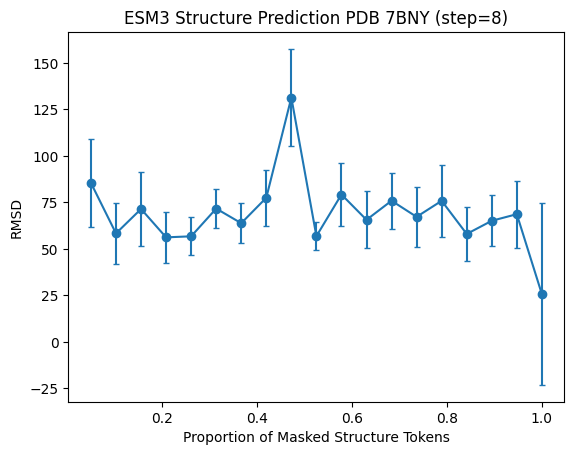

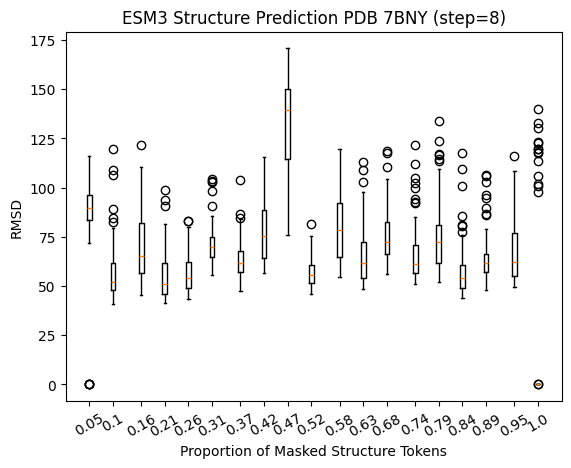

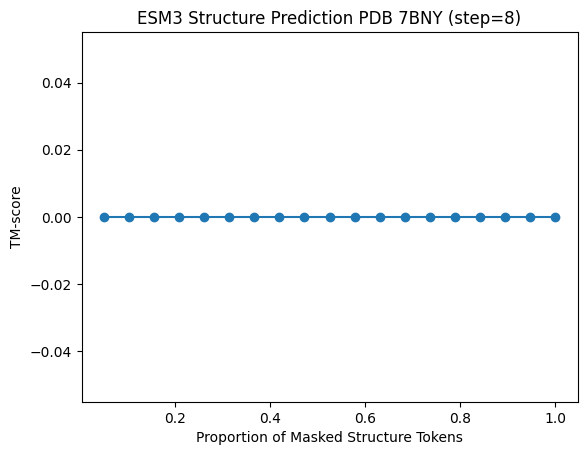

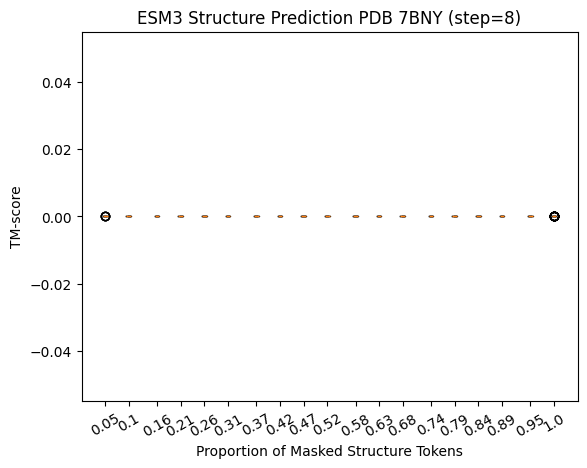

In [16]:
plt.errorbar(p_range, rmsd_list.mean(axis=1), yerr=rmsd_list.std(axis=1), fmt="o-", capsize=2.0)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("RMSD")
plt.show()

plt.boxplot(rmsd_list.T, positions=np.round(p_range, 2), widths=0.01)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("RMSD")
plt.xlim(0,1.05)
plt.xticks(rotation=30)
plt.show()

plt.errorbar(p_range, tm_list.mean(axis=1), yerr=tm_list.std(axis=1), fmt="o-", capsize=2.0)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("TM-score")
plt.show()

plt.boxplot(tm_list.T, positions=np.round(p_range, 2), widths=0.01)
plt.title("ESM3 Structure Prediction PDB 7BNY (step=8)")
plt.xlabel("Proportion of Masked Structure Tokens")
plt.ylabel("TM-score")
plt.xlim(0,1.05)
plt.xticks(rotation=30)
plt.show()

In [5]:
print("TM-score of ESMFoldV0: ", tmscore(true_coord[:, 1], torch.from_numpy(
    ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny_esmfoldv0.pdb", chain_id="A").atom37_positions[:, 1]))[1])
print("TM-score of ESMFoldV1: ", tmscore(true_coord[:, 1], torch.from_numpy(
    ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny_esmfold.pdb", chain_id="A").atom37_positions[:, 1]))[1])
print("TM-score of ESM3: ", tmscore(true_coord[:, 1], torch.from_numpy(
    ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny_esm3.pdb", chain_id="A").atom37_positions[:, 1]))[1])
print("TM-score of ColabFold: ", tmscore(true_coord[:, 1], torch.from_numpy(
    ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny_colabfold.pdb", chain_id="A").atom37_positions[:, 1]))[1])
print("TM-score of OmegaFold: ", tmscore(true_coord[:, 1], torch.from_numpy(
    ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7bny_omegafold.pdb", chain_id="A").atom37_positions[:, 1]))[1])
print("TM-score of ColabFold with HMMER MSA: ", tmscore(true_coord[:, 1], torch.from_numpy(
    ProteinChain.from_pdb("/home/jupyter-chenxi/data/7bny_example/7BNY_colabfold_hhblits_cb1d6_0.custom_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_000.pdb", chain_id="A").atom37_positions[:, 1]))[1])


TM-score of ESMFoldV0:  0.33033
TM-score of ESMFoldV1:  0.5513
TM-score of ESM3:  0.40875
TM-score of ColabFold:  0.52421
TM-score of OmegaFold:  0.35015
TM-score of ColabFold with HMMER MSA:  0.80656
